## <a name="abstract">Titanic Machine Learning From Disaster</a>

Abstract The sinking of the RMS Titanic is one of the most infamous shipwrecks in history. On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. This sensational tragedy shocked the international community and led to better safety regulations for ships.
One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew. Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as women, children, and the upper-class.
In this challenge, we ask you to complete the analysis of what sorts of people were likely to survive. In particular, we ask you to apply the tools of machine learning to predict which passengers survived the tragedy.

In [1]:
using DataFrames
using DecisionTree
using MLBase
using Gadfly

  likely near /Users/diego/.julia/v0.4/MLBase/src/modeltune.jl:5
  likely near /Users/diego/.julia/v0.4/MLBase/src/modeltune.jl:5
  likely near /Users/diego/.julia/v0.4/MLBase/src/modeltune.jl:5
  likely near /Users/diego/.julia/v0.4/MLBase/src/deprecated/datapre.jl:104
  likely near /Users/diego/.julia/v0.4/MLBase/src/deprecated/datapre.jl:105
  likely near /Users/diego/.julia/v0.4/MLBase/src/deprecated/datapre.jl:163
  likely near /Users/diego/.julia/v0.4/MLBase/src/deprecated/datapre.jl:163
  likely near /Users/diego/.julia/v0.4/MLBase/src/deprecated/datapre.jl:163


## Load Data

In [2]:
train = readtable("data/train.csv")
test = readtable("data/test.csv");

### Handle Missing Data

In [3]:
showcols(train)
showcols(test)

891x12 DataFrames.DataFrame
| Col # | Name        | Eltype     | Missing |
|-------|-------------|------------|---------|
| 1     | PassengerId | Int64 

In [4]:
most_frequenty_embarked_class = "S"
average_fare = mean(train[!isna(train[:Fare]), :Fare]);

In [5]:
train[isna(train[:Embarked]), :Embarked] = most_frequenty_embarked_class
test[isna(test[:Embarked]), :Embarked] = most_frequenty_embarked_class
test[isna(test[:Fare]), :Fare] = average_fare;

     | 0       |
| 2     | Survived    | Int64      | 0       |
| 3     | Pclass      | Int64      | 0       |
| 4     | Name        | UTF8String | 0       |
| 5     | Sex         | UTF8String | 0       |
| 6     | Age         | Float64    | 177     |
| 7     | SibSp       | Int64      | 0       |
| 8     | Parch       | Int64      | 0       |
| 9     | Ticket      | UTF8String | 0       |
| 10    | Fare        | Float64    | 0       |
| 11    | Cabin       | UTF8String | 687     |
| 12    | Embarked    | UTF8String | 2       |418x11 DataFrames.DataFrame
| Col # | Name        | Eltype     | Missing |
|-------|-------------|------------|---------|
| 1     | PassengerId | Int64      | 0       |
| 2     | Pclass      | Int64      | 0       |
| 3     | Name        | UTF8String | 0       |
| 4     | Sex         | UTF8String | 0       |
| 5     | Age         | Float64    | 86      |
| 6     | SibSp       | Int64      | 0       |
| 7     | Parch       | Int64      | 0       |
| 8     | Ticket

#### Infered Age with Regression Trees

In [6]:
data = vcat(train, test) 

age_features = [:Pclass, :Sex, :SibSp, :Parch, :Fare]
age_training_features = array(data[!isna(data[:Age]), age_features])
age_training_labels = array(data[!isna(data[:Age]), :Age])

model = build_tree(age_training_labels, age_training_features, 5)
train[isna(train[:Age]), :Age] = apply_tree(model, array(train[isna(train[:Age]), age_features]))
test[isna(test[:Age]), :Age] = apply_tree(model, array(test[isna(test[:Age]), age_features]));

 in depwarn at deprecated.jl:73
 in array at deprecated.jl:50
 in include_string at loading.jl:266
 in execute_request_0x535c5df2 at /Users/diego/.julia/v0.4/IJulia/src/execute_request.jl:177
 in eventloop at /Users/diego/.julia/v0.4/IJulia/src/IJulia.jl:141
 in anonymous at task.jl:447
while loading In[6], in expression starting on line 4


### Add New Features

#### Feature 1: Title

In [7]:
title_sir = ["Capt", "Don", "Major", "Master", "Sir", "Dr"]
title_lady = ["Don", "Lady", "the Countess", "Jonkheer"]
training_title_list = map(n -> split(strip(split(n, ",")[2]), ".")[1], train[:Name])
test_title_list = map(n -> split(strip(split(n, ",")[2]), ".")[1], test[:Name])
countmap(training_title_list)

 in depwarn at deprecated.jl:73
 in array at deprecated.jl:50
 in include_string at loading.jl:266
 in execute_request_0x535c5df2 at /Users/diego/.julia/v0.4/IJulia/src/execute_request.jl:177
 in eventloop at /Users/diego/.julia/v0.4/IJulia/src/IJulia.jl:141
 in anonymous at task.jl:447
while loading In[6], in expression starting on line 8


Dict{Any,Int64} with 17 entries:
  "Jonkheer"     => 1
  "Don"          => 1
  "the Countess" => 1
  "Master"       => 40
  "Miss"         => 182
  "Capt"         => 1
  "Mrs"          => 125
  "Rev"          => 6
  "Major"        => 2
  "Mr"           => 517
  "Mme"          => 1
  "Mlle"         => 2
  "Col"          => 2
  "Lady"         => 1
  "Sir"          => 1
  "Ms"           => 1
  "Dr"           => 7

In [8]:
is_in_title_list(names, title_list) = Array{Bool}(map(n -> n in title_list, names))
train[:Title] = training_title_list
train[is_in_title_list(training_title_list, title_sir), :Title] = "Sir."
train[is_in_title_list(training_title_list, title_lady), :Title] = "Lady."
test[:Title] = test_title_list
test[is_in_title_list(test_title_list, title_sir), :Title] = "Sir."
test[is_in_title_list(test_title_list, title_lady), :Title] = "Lady.";

#### Feature 2: Family Size

In [9]:
train[:FamilySize] = train[:Parch] .+ train[:SibSp] .+ 1
test[:FamilySize] = test[:Parch] .+ test[:SibSp] .+ 1;

#### Feature 3: Is Mother?

In [10]:
is_mother(df) = Array{Bool}(map(i -> df[i, :Parch] > 0 && df[i, :Age] > 18 && df[i, :Title] != "Miss", vcat(1:size(df,1))))
train[:IsMother] = 0
train[is_mother(train), :IsMother] = 1
test[:IsMother] = 0
test[is_mother(test), :IsMother] = 1;

#### Feature 4: Is Child?

In [11]:
is_child(df) = Array{Bool}(map(i -> df[i, :Parch] > 0 && df[i, :Age] <= 18, size(df,1)))
train[:IsChild] = 0
train[is_child(train), :IsChild] = 1
test[:IsChild] = 0
test[is_child(test), :IsChild] = 1;

#### Feature 5: Family Size 2

In [12]:
get_surname(name) = strip(split(name, ",")[1])
surname_freq = countmap(map(n -> get_surname(n), vcat(train[:Name], test[:Name])))
is_small_family(names) = map(n -> surname_freq[get_surname(n)] > 2? 0 : 1, names);
train[:IsSmallFamily] = is_small_family(train[:Name])
test[:IsSmallFamily] = is_small_family(test[:Name]);

#### Features 6-7: Cabin Prefix and Number

In [13]:
get_cabin_prefix(cabins) = map(c -> !isna(c)? string(c[1]) : NA, cabins)
get_cabin_number(cabins) = Array{AbstractString}(map(c ->  !isna(c)? string(c[2:end]) : "-1", cabins))
train[:CabinPrefix] = get_cabin_prefix(train[:Cabin])
train[:CabinNumber] = get_cabin_number(train[:Cabin])
test[:CabinPrefix] = get_cabin_prefix(test[:Cabin])
test[:CabinNumber] = get_cabin_number(test[:Cabin]);

In [14]:
data = vcat(train, test)
cabin_prefix_labels = labelmap(Array{AbstractString}(dropna(data[:CabinPrefix])));

train[!isna(train[:CabinPrefix]), :CabinPrefix] = labelencode(cabin_prefix_labels, Array{AbstractString}(train[!isna(train[:CabinPrefix]), :CabinPrefix]))
test[!isna(test[:CabinPrefix]), :CabinPrefix] = labelencode(cabin_prefix_labels, Array{AbstractString}(test[!isna(test[:CabinPrefix]), :CabinPrefix]))
data[!isna(data[:CabinPrefix]), :CabinPrefix] = labelencode(cabin_prefix_labels, Array{AbstractString}(data[!isna(data[:CabinPrefix]), :CabinPrefix]));

In [15]:
cabin_prefix_features = [:Pclass, :Sex, :Age, :SibSp, :Parch, :Fare, :Embarked, 
                         :Title, :FamilySize, :IsMother, :IsChild, :IsSmallFamily]
cabin_prefix_training_features = array(data[!isna(data[:CabinPrefix]), cabin_prefix_features])
cabin_prefix_training_labels = array(data[!isna(data[:CabinPrefix]), :CabinPrefix])

model = build_tree(cabin_prefix_training_labels, cabin_prefix_training_features, 5)
train[isna(train[:CabinPrefix]), :CabinPrefix] = apply_tree(model, array(train[isna(train[:CabinPrefix]), cabin_prefix_features]))
test[isna(test[:CabinPrefix]), :CabinPrefix] = apply_tree(model, array(test[isna(test[:CabinPrefix]), cabin_prefix_features]));

#### Encode Categorical Fields

In [16]:
categorical_fields_to_encode = [:Sex, :Title, :Embarked, :IsSmallFamily, 
                                :CabinPrefix, :CabinNumber]
labels = map(c -> labelmap(vcat(train[c], test[c])), categorical_fields_to_encode)
for (i, c) in enumerate(categorical_fields_to_encode)
    train[c] = labelencode(labels[i], train[c])
    test[c] = labelencode(labels[i], test[c])
end

### Export Enriched Training/Test Sets

In [27]:
writetable("./data/train_enriched.tsv", train, separator='\t')
writetable("./data/test_enriched.tsv", test, separator='\t');

### Prepare Training/Validation Set

In [18]:
features_names = [:Pclass, :Sex, :Age, :SibSp, :Parch, :Fare, :Embarked, 
                  :Title, :FamilySize, :IsMother, :IsChild, :IsSmallFamily, 
                  :CabinPrefix, :CabinNumber]
training_features = array(train[:, features_names])
training_labels = array(train[:, :Survived])
test_features = array(test[:, features_names]);

### Training & Evaluation

In [21]:
average_time = 10
cv = 5
random_features = []
number_trees = []
splits = []
accs = []
iteration = 0
nt=100
sp=.7
for rf=1:10
    iteration += 1
    average_acc = mean(nfoldCV_forest(training_labels, training_features, rf, nt, cv, sp))
    println("Iteration $iteration: RF:$rf, NT:$nt, SP:$sp, AVG_ACC: $(round(average_acc*100, 2))")
    push!(random_features, rf)
    push!(number_trees, nt)
    push!(splits, sp)
    push!(accs, average_acc)
end


Fold 1

2x2 Array{Int64,2}:
 96   8
 33  41


Classes:  Any[0,1]
Matrix:   
Accuracy: 0.7696629213483146
Kappa:    0.5015708236579702

Fold 2

2x2 Array{Int64,2}:
 105   4
  40  29


Classes:  Any[0,1]
Matrix:   
Accuracy: 0.7528089887640449
Kappa:    0.4242023231877664

Fold 3

2x2 Array{Int64,2}:
 103   5
  30  40


Classes:  Any[0,1]
Matrix:   
Accuracy: 0.8033707865168539
Kappa:    0.5603387438249823

Fold 4

2x2 Array{Int64,2}:
 106   1
  35  36


Classes:  Any[0,1]
Matrix:   
Accuracy: 0.797752808988764
Kappa:    0.5413027916964924

Fold 5

2x2 Array{Int64,2}:
 114   6
  22  36


Classes:  Any[0,1]
Matrix:   
Accuracy: 0.8426966292134831
Kappa:    0.6144801980198018

Mean Accuracy: 0.7932584269662921
Iteration 1: RF:1, NT:100, SP:0.7, AVG_ACC: 79.33

Fold 1

2x2 Array{Int64,2}:
 103  11
  20  44


Classes:  Any[0,1]
Matrix:   
Accuracy: 0.8258426966292135
Kappa:    0.6098147362466413

Fold 2

2x2 Array{Int64,2}:
 106  11
  16  45


Classes:  Any[0,1]
Matrix:   
Accuracy: 0.848314606741573
Kappa:    0.6565671001857939

Fold 3

2x2 Array{Int64,2}:
 95  14
 20  49


Classes:  Any[0,1]
Matrix:   
Accuracy: 0.8089887640449438
Kappa:    0.5911363329279826

Fold 4

2x2 Array{Int64,2}:
 92   4
 28  54


Classes:  Any[0,1]
Matrix:   
Accuracy: 0.8202247191011236
Kappa:    0.6303219106957424

Fold 5

2x2 Array{Int64,2}:
 99  13
 20  46


Classes:  Any[0,1]
Matrix:   
Accuracy: 0.8146067415730337
Kappa:    0.5938321117411147

Mean Accuracy: 0.8235955056179776
Iteration 2: RF:2, NT:100, SP:0.7, AVG_ACC: 82.36

Fold 1

2x2 Array{Int64,2}:
 101  11
  17  49


Classes:  Any[0,1]
Matrix:   
Accuracy: 0.8426966292134831
Kappa:    0.6564653984008821

Fold 2

2x2 Array{Int64,2}:
 103   8
  22  45


Classes:  Any[0,1]
Matrix:   
Accuracy: 0.8314606741573034
Kappa:    0.6254734184317576

Fold 3

2x2 Array{Int64,2}:
 105  10
  20  43


Classes:  Any[0,1]
Matrix:   
Accuracy: 0.8314606741573034
Kappa:    0.6177523264137438

Fold 4

2x2 Array{Int64,2}:
 89  14
 22  53


Classes:  Any[0,1]
Matrix:   
Accuracy: 0.797752808988764
Kappa:    0.5791409431236042

Fold 5

2x2 Array{Int64,2}:
 97  10
 17  54


Classes:  Any[0,1]
Matrix:   
Accuracy: 0.848314606741573
Kappa:    0.6783563110694685

Mean Accuracy: 0.8303370786516853
Iteration 3: RF:3, NT:100, SP:0.7, AVG_ACC: 83.03

Fold 1

2x2 Array{Int64,2}:
 94  15
 22  47


Classes:  Any[0,1]
Matrix:   
Accuracy: 0.7921348314606742
Kappa:    0.5538544912613468

Fold 2

2x2 Array{Int64,2}:
 103  13
  17  45


Classes:  Any[0,1]
Matrix:   
Accuracy: 0.8314606741573034
Kappa:    0.6230942970073405

Fold 3

2x2 Array{Int64,2}:
 99  11
 21  47


Classes:  Any[0,1]
Matrix:   
Accuracy: 0.8202247191011236
Kappa:    0.6082530949105914

Fold 4

2x2 Array{Int64,2}:
 91  15
 16  56


Classes:  Any[0,1]
Matrix:   
Accuracy: 0.8258426966292135
Kappa:    0.6376887721602101

Fold 5

2x2 Array{Int64,2}:
 101   7
  21  49


Classes:  Any[0,1]
Matrix:   
Accuracy: 0.8426966292134831
Kappa:    0.658349328214971

Mean Accuracy: 0.8224719101123595
Iteration 4: RF:4, NT:100, SP:0.7, AVG_ACC: 82.25

Fold 1

2x2 Array{Int64,2}:
 100   7
  22  49


Classes:  Any[0,1]
Matrix:   
Accuracy: 0.8370786516853933
Kappa:    0.647741231063191

Fold 2

2x2 Array{Int64,2}:
 106   6
  20  46


Classes:  Any[0,1]
Matrix:   
Accuracy: 0.8539325842696629
Kappa:    0.6727015558698727

Fold 3

2x2 Array{Int64,2}:
 104  13
  12  49


Classes:  Any[0,1]
Matrix:   
Accuracy: 0.8595505617977528
Kappa:    0.6894626657362177

Fold 4

2x2 Array{Int64,2}:
 98  12
 16  52


Classes:  Any[0,1]
Matrix:   
Accuracy: 0.8426966292134831
Kappa:    0.6630611141157382

Fold 5

2x2 Array{Int64,2}:
 86  16
 21  55


Classes:  Any[0,1]
Matrix:   
Accuracy: 0.7921348314606742
Kappa:    0.5716144139456225

Mean Accuracy: 0.8370786516853933
Iteration 5: RF:5, NT:100, SP:0.7, AVG_ACC: 83.71

Fold 1

2x2 Array{Int64,2}:
 104  10
  13  51


Classes:  Any[0,1]
Matrix:   
Accuracy: 0.8707865168539326
Kappa:    0.7165212574435674

Fold 2

2x2 Array{Int64,2}:
 93  10
 22  53


Classes:  Any[0,1]
Matrix:   
Accuracy: 0.8202247191011236
Kappa:    0.623130872039169

Fold 3

2x2 Array{Int64,2}:
 104   8
  22  44


Classes:  Any[0,1]
Matrix:   
Accuracy: 0.8314606741573034
Kappa:    0.6223479490806224

Fold 4

2x2 Array{Int64,2}:
 88  20
 18  52


Classes:  Any[0,1]
Matrix:   
Accuracy: 0.7865168539325843
Kappa:    0.5548828639115557

Fold 5

2x2 Array{Int64,2}:
 102   9
  14  53


Classes:  Any[0,1]
Matrix:   
Accuracy: 0.8707865168539326
Kappa:    0.7206223556708067

Mean Accuracy: 0.8359550561797754
Iteration 6: RF:6, NT:100, SP:0.7, AVG_ACC: 83.6

Fold 1

2x2 Array{Int64,2}:
 104  18
  13  43


Classes:  Any[0,1]
Matrix:   
Accuracy: 0.8258426966292135
Kappa:    0.6056881520651709

Fold 2

2x2 Array{Int64,2}:
 104  12
  17  45


Classes:  Any[0,1]
Matrix:   
Accuracy: 0.8370786516853933
Kappa:    0.6342638514949696

Fold 3

2x2 Array{Int64,2}:
 89  16
 13  60


Classes:  Any[0,1]
Matrix:   
Accuracy: 0.8370786516853933
Kappa:    0.6653701542849735

Fold 4

2x2 Array{Int64,2}:
 89   6
 20  63


Classes:  Any[0,1]
Matrix:   
Accuracy: 0.8539325842696629
Kappa:    0.7033713626458146

Fold 5

2x2 Array{Int64,2}:
 102   9
  17  50


Classes:  Any[0,1]
Matrix:   
Accuracy: 0.8539325842696629
Kappa:    0.6813111141716016

Mean Accuracy: 0.8415730337078651
Iteration 7: RF:7, NT:100, SP:0.7, AVG_ACC: 84.16

Fold 1

2x2 Array{Int64,2}:
 95  16
 17  50


Classes:  Any[0,1]
Matrix:   
Accuracy: 0.8146067415730337
Kappa:    0.6039109912339852

Fold 2

2x2 Array{Int64,2}:
 92   5
 18  63


Classes:  Any[0,1]
Matrix:   
Accuracy: 0.8707865168539326
Kappa:    0.7359731716754805

Fold 3

2x2 Array{Int64,2}:
 103   6
  22  47


Classes:  Any[0,1]
Matrix:   
Accuracy: 0.8426966292134831
Kappa:    0.6539369532009442

Fold 4

2x2 Array{Int64,2}:
 96  15
 16  51


Classes:  Any[0,1]
Matrix:   
Accuracy: 0.8258426966292135
Kappa:    0.6279163857046528

Fold 5

2x2 Array{Int64,2}:
 105  15
  18  40


Classes:  Any[0,1]
Matrix:   
Accuracy: 0.8146067415730337
Kappa:    0.5723023154215815

Mean Accuracy: 0.8337078651685393
Iteration 8: RF:8, NT:100, SP:0.7, AVG_ACC: 83.37

Fold 1

2x2 Array{Int64,2}:
 98   8
 25  47


Classes:  Any[0,1]
Matrix:   
Accuracy: 0.8146067415730337
Kappa:    0.6000272368241863

Fold 2

2x2 Array{Int64,2}:
 95  15
 17  51


Classes:  Any[0,1]
Matrix:   
Accuracy: 0.8202247191011236
Kappa:    0.6171013713363808

Fold 3

2x2 Array{Int64,2}:
 106  10
  15  47


Classes:  Any[0,1]
Matrix:   
Accuracy: 0.8595505617977528
Kappa:    0.6847102168060082

Fold 4

2x2 Array{Int64,2}:
 101   7
  13  57


Classes:  Any[0,1]
Matrix:   
Accuracy: 0.8876404494382022
Kappa:    0.7609454740800429

Fold 5

2x2 Array{Int64,2}:
 91  17
 23  47


Classes:  Any[0,1]
Matrix:   
Accuracy: 0.7752808988764045
Kappa:    0.521890948160086

Mean Accuracy: 0.8314606741573034
Iteration 9: RF:9, NT:100, SP:0.7, AVG_ACC: 83.15

Fold 1

2x2 Array{Int64,2}:
 88  18
 15  57


Classes:  Any[0,1]
Matrix:   
Accuracy: 0.8146067415730337
Kappa:    0.6177274502147598

Fold 2

2x2 Array{Int64,2}:
 104   8
  19  47


Classes:  Any[0,1]
Matrix:   
Accuracy: 0.848314606741573
Kappa:    0.6633982350469253

Fold 3

2x2 Array{Int64,2}:
 98  12
 27  41


Classes:  Any[0,1]
Matrix:   
Accuracy: 0.7808988764044944
Kappa:    0.5155617585484997

Fold 4

2x2 Array{Int64,2}:
 100  11
  16  51


Classes:  Any[0,1]
Matrix:   
Accuracy: 0.848314606741573
Kappa:    0.6720349392657294

Fold 5

2x2 Array{Int64,2}:
 93  17
 15  53


Classes:  Any[0,1]
Matrix:   
Accuracy: 0.8202247191011236
Kappa:    0.6213772932730657

Mean Accuracy: 0.8224719101123596
Iteration 10: RF:10, NT:100, SP:0.7, AVG_ACC: 82.25


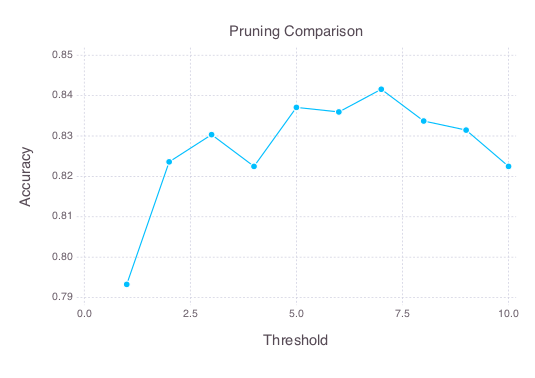

In [22]:
plot(x=vcat(1:10), y=accs, Geom.point, Geom.line, Guide.xlabel("Threshold"), Guide.ylabel("Accuracy"), Guide.title("Pruning Comparison"))

### Use Best Evaluated Model to Predict

In [24]:
model = build_forest(training_labels, training_features, 5, 600, .7)
predicted_values = apply_forest(model, test_features);

### Save Best Model

In [25]:
prediction_dataframe = DataFrame(PassengerId=test[:PassengerId], Survived=predicted_values)
writetable("./data/prediction_v6_random_forest_5randfeat_600trees_.7split_cv5_feat_engineering.csv", prediction_dataframe);

### Results on Kaggle

<div style="background-color:#c1f5ba; color:#30b171; padding:5px;
            font-family:'Lucida Sans Unicode', 'Lucida Grande', sans-serif">
    Results from this submission on Kaggle: **0.78469**
</div>